# Application of Machine Learning to Stock Market Index Prediction

Code adapted from: https://github.com/dataquestio/project-walkthroughs/tree/master/sp_500

## Imported Libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline
import mplfinance as mpf
import cufflinks as cf #plotly dependency
import chart_studio.plotly as py #plotly dependency
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
import plotly.graph_objects as go 

from datetime import datetime
init_notebook_mode(connected=True)
cf.go_offline()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score



## 1. Data Extraction and Cleansing

In [3]:
if (os.path.exists("sp500.csv") & os.path.exists("sp500all.csv") 
    & os.path.exists("spy.csv") & os.path.exists("spyall.csv")):
    
    sp500 = pd.read_csv("sp500.csv", index_col=0)
    sp500all = pd.read_csv("sp500all.csv", index_col=0)
    spy = pd.read_csv("spy.csv", index_col=0)
    spyall = pd.read_csv("spyall.csv", index_col=0)
else:

    sp500 = yf.download("^GSPC",period='30y')
    sp500all = yf.download("^GSPC",period='max')
    sp500all.to_csv("sp500all.csv")
    sp500.to_csv("sp500.csv")

    spy = yf.download("SPY",period='30y')
    spyall = yf.download("SPY",period='max')
    spyall.to_csv("spyall.csv")
    spy.to_csv("spy.csv")

In [4]:
spy.index = pd.to_datetime(spy.index)
spyall.index = pd.to_datetime(spyall.index)
sp500.index = pd.to_datetime(sp500.index)
sp500all.index = pd.to_datetime(sp500all.index)

In [5]:
years30_ago_price = spy['Close'][0]
actual_price = spy['Close'][-1]

## 2. Data Visualization

### S&P500 AND SPY COMPARISON

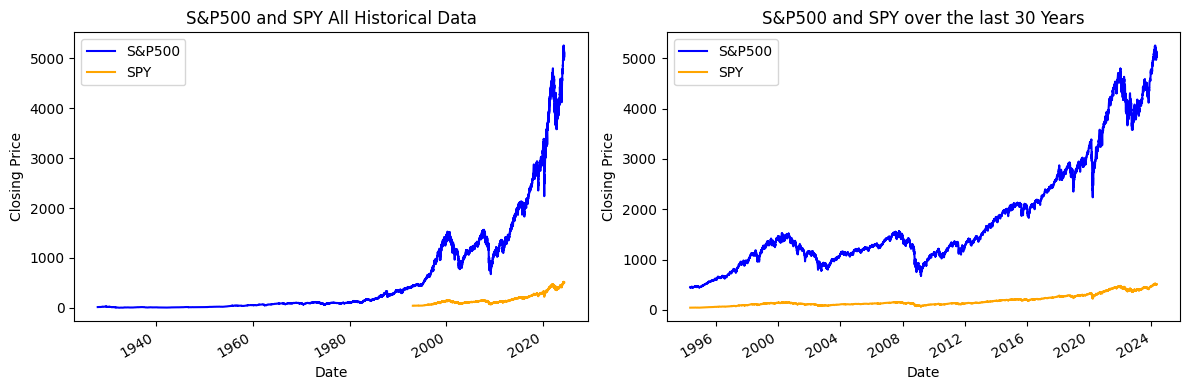

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))

sp500all.plot.line(y="Close", use_index=True,ax=axes[0],color='Blue',label='S&P500')
spyall.plot.line(y="Close", use_index=True,ax=axes[0],color='Orange',label='SPY')
axes[0].set_title("S&P500 and SPY All Historical Data")
axes[0].set_ylabel('Closing Price')
axes[0].set_xlabel('Date')

sp500.plot.line(y="Close", use_index=True,ax=axes[1],color='Blue',label='S&P500')
spy.plot.line(y="Close", use_index=True,ax=axes[1],color='Orange',label='SPY')
axes[1].set_title("S&P500 and SPY over the last 30 Years")
axes[1].set_ylabel('Closing Price')
axes[1].set_xlabel('Date')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()   

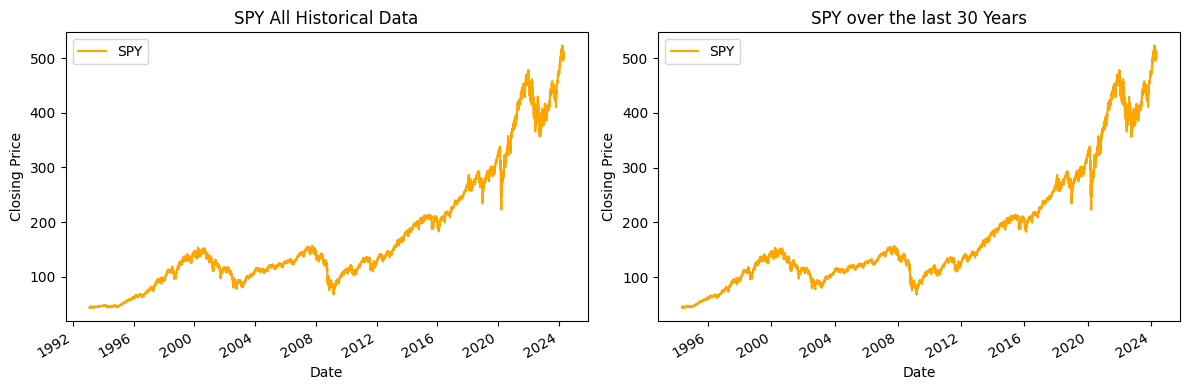

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))

spyall.plot.line(y="Close", use_index=True,ax=axes[0],color='Orange',label='SPY')
axes[0].set_title("SPY All Historical Data")
axes[0].set_ylabel('Closing Price')
axes[0].set_xlabel('Date')

spy.plot.line(y="Close", use_index=True,ax=axes[1],color='Orange',label='SPY')
axes[1].set_title("SPY over the last 30 Years")
axes[1].set_ylabel('Closing Price')
axes[1].set_xlabel('Date')

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

### SPY CANDLESTICK VISUALIZATION

In [223]:
#spy[('Open,Close,High,Low').split(",")].iplot()
go.Figure(data=[go.Candlestick(x=spy.index,open=spy['Open'],high=spy['High'],low=spy['Low'],close=spy['Close'])])

### Defining the Target for the predictions

In [224]:
spy["Tomorrow"] = spy["Close"].shift(-1)
spy["Target"] = (spy["Tomorrow"] > spy["Close"]).astype(int)
spy

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target
Date,,,,,,,,
1994-05-04,45.421875,45.421875,45.078125,45.250000,26.294889,401900,45.187500,0
1994-05-05,45.296875,45.375000,45.187500,45.187500,26.258566,659800,44.750000,0
1994-05-06,44.968750,44.968750,44.593750,44.750000,26.004328,216300,44.359375,0
1994-05-09,44.625000,44.750000,44.281250,44.359375,25.777321,499300,44.703125,1
1994-05-10,44.578125,44.843750,44.546875,44.703125,25.977097,583400,44.296875,0
...,...,...,...,...,...,...,...,...
2024-04-29,510.089996,510.750000,507.250000,510.059998,510.059998,46415400,501.980011,0
2024-04-30,508.559998,509.559998,501.980011,501.980011,501.980011,77483600,500.350006,0
2024-05-01,501.380005,508.190002,499.869995,500.350006,500.350006,80242800,505.029999,1


## 3. Data Splitting

In [225]:
# Do not use cross validation cause it does not take into consideration time series
#X = spy[["Close", "Volume", "Open", "High", "Low"]]
#y = spy.index
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [226]:
#Dataset Splitting & Predictors
train = spy.iloc[:-300]
test = spy.iloc[-300:]
predictors = ["Close", "Volume", "Open", "High", "Low"]

## 4. Selecting Optimal Parameters for the Random Forest Classifier

In [227]:
estimators = [100,200,300,400,500]
samples_splits = [100,150,200,250,300]
scores = []
models = []

for i in estimators:
    samples = []
    model_iteration = []
    for j in samples_splits:
        model = RandomForestClassifier(n_estimators=i, min_samples_split=j, random_state=1)
        model.fit(train[predictors], train["Target"])
        model_iteration.append(model)

        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        accuracy = precision_score(test['Target'], preds)
        
        samples.append(accuracy)

    models.append(model_iteration)
    scores.append(samples)


In [228]:
models

[[RandomForestClassifier(min_samples_split=100, random_state=1),
  RandomForestClassifier(min_samples_split=150, random_state=1),
  RandomForestClassifier(min_samples_split=200, random_state=1),
  RandomForestClassifier(min_samples_split=250, random_state=1),
  RandomForestClassifier(min_samples_split=300, random_state=1)],
 [RandomForestClassifier(min_samples_split=100, n_estimators=200, random_state=1),
  RandomForestClassifier(min_samples_split=150, n_estimators=200, random_state=1),
  RandomForestClassifier(min_samples_split=200, n_estimators=200, random_state=1),
  RandomForestClassifier(min_samples_split=250, n_estimators=200, random_state=1),
  RandomForestClassifier(min_samples_split=300, n_estimators=200, random_state=1)],
 [RandomForestClassifier(min_samples_split=100, n_estimators=300, random_state=1),
  RandomForestClassifier(min_samples_split=150, n_estimators=300, random_state=1),
  RandomForestClassifier(min_samples_split=200, n_estimators=300, random_state=1),
  RandomF

In [229]:
for samples in scores:
    print(samples)

[0.5130434782608696, 0.53125, 0.536, 0.5185185185185185, 0.4954128440366973]
[0.5130434782608696, 0.5583333333333333, 0.504424778761062, 0.5, 0.5641025641025641]
[0.5163934426229508, 0.5303030303030303, 0.5081967213114754, 0.5096153846153846, 0.5319148936170213]
[0.5196850393700787, 0.5238095238095238, 0.5042016806722689, 0.52, 0.5257731958762887]
[0.5161290322580645, 0.5166666666666667, 0.5128205128205128, 0.5050505050505051, 0.5]


In [312]:

scores_comparison= pd.DataFrame(scores,estimators,samples_splits).transpose()
scores_comparison.index.names = ['min_sample_split']
scores_comparison.columns=pd.MultiIndex.from_product([['Number of estimators'],scores_comparison.columns])

scores_comparison

Number of estimators                                        
                                  100       200       300       400       500
min_sample_split                                                             
100                          0.513043  0.513043  0.516393  0.519685  0.516129
150                          0.531250  0.558333  0.530303  0.523810  0.516667
200                          0.536000  0.504425  0.508197  0.504202  0.512821
250                          0.518519  0.500000  0.509615  0.520000  0.505051
300                          0.495413  0.564103  0.531915  0.525773  0.500000

In [313]:
scores_comparison.max()

Number of estimators  100    0.536000
                      200    0.564103
                      300    0.531915
                      400    0.525773
                      500    0.516667
dtype: float64

<Axes: xlabel='min_sample_split'>

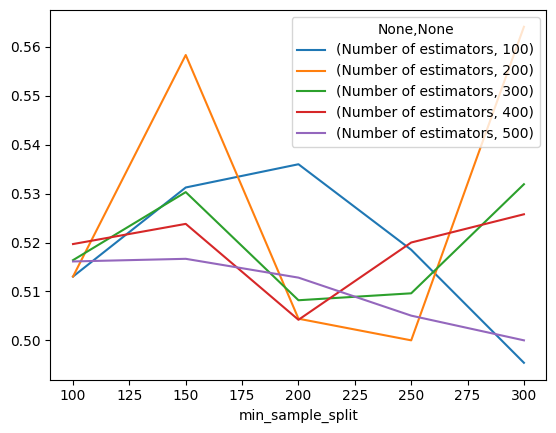

In [314]:
scores_comparison.plot()
#scores_comparison.iplot()

## 5. Random Forest Model Training

In [233]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=300, random_state=1)
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=300, n_estimators=200, random_state=1)

In [234]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test['Target'], preds)

0.5641025641025641

## 6. Predictions & Target Comparison

In [235]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.rename(columns = {0:'Prediction'},inplace= True)
combined

,Target,Prediction
Date,,
2023-02-24,1,0
2023-02-27,0,0
2023-02-28,0,0
2023-03-01,1,0
2023-03-02,1,0
...,...,...
2024-04-29,0,0
2024-04-30,0,0
2024-05-01,1,0


<Axes: xlabel='Date'>

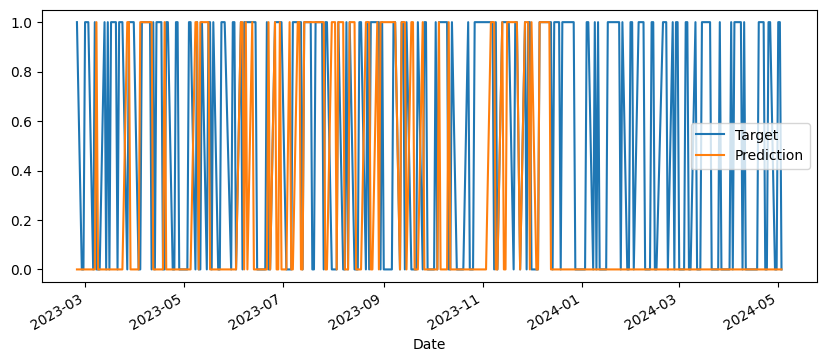

In [236]:
combined.plot(figsize=(10,4))

## 7. Back Testing Implementation

In [237]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [238]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [239]:
predictions = backtest(spy, model, predictors)

In [240]:
predictions["Predictions"].value_counts()

Predictions
1    3285
0    1769
Name: count, dtype: int64

In [241]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5452054794520548

In [242]:
#Prediction Percentages
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.543134
0    0.456866
Name: count, dtype: float64

## 8. Addition of New Predictors

In [243]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = spy.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    spy[ratio_column] = spy["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    spy[trend_column] = spy.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [244]:
spy = spy.dropna(subset=spy.columns[spy.columns != "Tomorrow"])

In [245]:
spy = spy.dropna()

In [246]:
spy

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,
1998-04-20,112.000000,112.562500,111.875000,112.250000,70.753159,3688300,112.781250,1,0.999861,1.0,1.003520,3.0,1.059947,34.0,1.177964,136.0,1.644349,544.0
1998-04-21,112.437500,113.156250,111.906250,112.781250,71.088005,4573200,113.093750,1,1.002361,1.0,1.006526,3.0,1.062147,35.0,1.181804,136.0,1.650497,545.0
1998-04-22,112.875000,113.437500,112.812500,113.093750,71.285011,2386100,112.000000,0,1.001384,2.0,1.007573,3.0,1.062220,36.0,1.183309,137.0,1.653416,546.0
1998-04-23,112.625000,113.000000,111.750000,112.000000,70.595596,5062000,110.812500,0,0.995141,1.0,0.995722,3.0,1.049457,35.0,1.170128,137.0,1.635808,546.0
1998-04-24,111.750000,112.468750,110.343750,110.812500,69.847122,11039700,108.718750,0,0.994670,0.0,0.987744,2.0,1.036211,34.0,1.156102,136.0,1.616903,545.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,506.350006,509.880005,505.700012,508.260010,508.260010,64306100,510.059998,1,1.004715,1.0,1.007441,3.0,0.999437,30.0,1.106209,136.0,1.230923,536.0
2024-04-29,510.089996,510.750000,507.250000,510.059998,510.059998,46415400,501.980011,0,1.001768,2.0,1.006882,3.0,1.002291,30.0,1.109214,137.0,1.234617,536.0
2024-04-30,508.559998,509.559998,501.980011,501.980011,501.980011,77483600,500.350006,0,0.992016,1.0,0.992369,2.0,0.986167,29.0,1.090778,137.0,1.214443,535.0


In [327]:
predictions = backtest(spy, model, predictors)

In [247]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=300, random_state=1)

In [248]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [249]:
predictions = backtest(spy, model, new_predictors)

In [250]:
predictions["Predictions"].value_counts()

Predictions
0.0    3916
1.0     137
Name: count, dtype: int64

In [251]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5547445255474452

In [252]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.544535
0    0.455465
Name: count, dtype: float64

In [253]:
predictions

,Target,Predictions
Date,,
2008-03-28,1,0.0
2008-03-31,1,0.0
2008-04-01,1,0.0
2008-04-02,1,0.0
2008-04-03,0,0.0
...,...,...
2024-04-26,1,0.0
2024-04-29,0,0.0
2024-04-30,0,0.0


In [254]:
spy

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,
1998-04-20,112.000000,112.562500,111.875000,112.250000,70.753159,3688300,112.781250,1,0.999861,1.0,1.003520,3.0,1.059947,34.0,1.177964,136.0,1.644349,544.0
1998-04-21,112.437500,113.156250,111.906250,112.781250,71.088005,4573200,113.093750,1,1.002361,1.0,1.006526,3.0,1.062147,35.0,1.181804,136.0,1.650497,545.0
1998-04-22,112.875000,113.437500,112.812500,113.093750,71.285011,2386100,112.000000,0,1.001384,2.0,1.007573,3.0,1.062220,36.0,1.183309,137.0,1.653416,546.0
1998-04-23,112.625000,113.000000,111.750000,112.000000,70.595596,5062000,110.812500,0,0.995141,1.0,0.995722,3.0,1.049457,35.0,1.170128,137.0,1.635808,546.0
1998-04-24,111.750000,112.468750,110.343750,110.812500,69.847122,11039700,108.718750,0,0.994670,0.0,0.987744,2.0,1.036211,34.0,1.156102,136.0,1.616903,545.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,506.350006,509.880005,505.700012,508.260010,508.260010,64306100,510.059998,1,1.004715,1.0,1.007441,3.0,0.999437,30.0,1.106209,136.0,1.230923,536.0
2024-04-29,510.089996,510.750000,507.250000,510.059998,510.059998,46415400,501.980011,0,1.001768,2.0,1.006882,3.0,1.002291,30.0,1.109214,137.0,1.234617,536.0
2024-04-30,508.559998,509.559998,501.980011,501.980011,501.980011,77483600,500.350006,0,0.992016,1.0,0.992369,2.0,0.986167,29.0,1.090778,137.0,1.214443,535.0


## 9. Profitability Oportunities According to the Different Investment Strategies

## Buy and Hold Strategy

In [255]:
spy['Close']

Date
1998-04-20    112.250000
1998-04-21    112.781250
1998-04-22    113.093750
1998-04-23    112.000000
1998-04-24    110.812500
                 ...    
2024-04-26    508.260010
2024-04-29    510.059998
2024-04-30    501.980011
2024-05-01    500.350006
2024-05-02    505.029999
Name: Close, Length: 6553, dtype: float64

In [256]:


# Buy and Hold Strategy
#years30_ago_price = spy['Close'][0]
#actual_price = spy['Close'][-1]
euro_dollar = 0.8488
investment = [100,1000,10000,100000] # Initial investment value in Euros Dolars

buy_and_hold = []
for i in investment:
    shares = (i/euro_dollar)/years30_ago_price
    value_added = actual_price*shares
    buy_and_hold.append(value_added)

buy_and_hold

[1331.2001305578547,
 13312.001305578546,
 133120.01305578547,
 1331200.1305578544]

### Profit and Shares

In [326]:
years30_ago_price*euro_dollar

38.4082

In [315]:
shares=(1000/euro_dollar)/years30_ago_price
shares

26.036106873011494

In [316]:

shares*spy['Close'][-1]

13149.015022294638

In [317]:
spy['Predictions'] = predictions['Predictions']
spy = spy.dropna()

## Daily Traiding Aided with ML Model

In [318]:
#buy at close and sell tomorrow

def prediction_model(euros):
    investment = euros/euro_dollar
    shares_pred = investment/years30_ago_price
    shares_target = investment/years30_ago_price
    gains_pred = []
    gains_target = []

    if [spy['Predictions']==1]:
        gains_pred = shares_pred*spy["Tomorrow"]
        shares_pred=gains_pred/spy['Close']
        


    if [spy['Target']==1]:
        gains_target = shares_target*spy["Open"].shift(-1)
        shares_target=gains_target/spy['Close']
        
    
    gained_profit = pd.concat([gains_pred,gains_target],axis=1)
    gained_profit['Target'] = gained_profit['Open']
    gained_profit['Predicted'] = gained_profit['Tomorrow']
    del gained_profit['Tomorrow']
    del gained_profit['Open']
    gained_profit["Signal"] = (gained_profit["Predicted"] > gained_profit["Target"]).astype(int)
    return gained_profit


In [328]:
gained_profit = prediction_model(1000)
gained_profit

,Target,Predicted,Signal
Date,,,
2008-03-28,3418.280297,3435.985056,1
2008-03-31,3478.684255,3556.792576,1
2008-04-01,3568.248526,3559.135730,0
2008-04-02,3539.869265,3567.987911,1
2008-04-03,3570.070847,3564.082654,0
...,...,...,...
2024-04-26,13280.757660,13279.976608,0
2024-04-29,13240.922448,13069.605214,0
2024-04-30,13053.983391,13027.166233,0


In [320]:
#Compound Effect
prediction_model(100000)

,Target,Predicted,Signal
Date,,,
2008-03-28,3.418280e+05,3.435985e+05,1
2008-03-31,3.478684e+05,3.556793e+05,1
2008-04-01,3.568249e+05,3.559136e+05,0
2008-04-02,3.539869e+05,3.567988e+05,1
2008-04-03,3.570071e+05,3.564083e+05,0
...,...,...,...
2024-04-26,1.328076e+06,1.327998e+06,0
2024-04-29,1.324092e+06,1.306961e+06,0
2024-04-30,1.305398e+06,1.302717e+06,0


In [321]:
positive_trend = gained_profit.loc[gained_profit["Signal"] == 1, "Predicted"]

In [322]:
#fuction to view the performance of specific periods of time

def date_period(year):
    plt.figure(figsize=(12,6))
    if [gained_profit["Signal"] == 1]:
        plt.plot(positive_trend[year],label="Gains Predicted")
    plt.plot(gained_profit['Target'][year],label='Real Gains',lw=1)
    plt.xlabel("Date")
    plt.ylabel('value in EU')
    plt.title(f"Results Comparison {year}")
    #plt.autofmt_xdate()
    #plt.xticks(date_to_show_as_list,rotation=90)
    plt.legend()


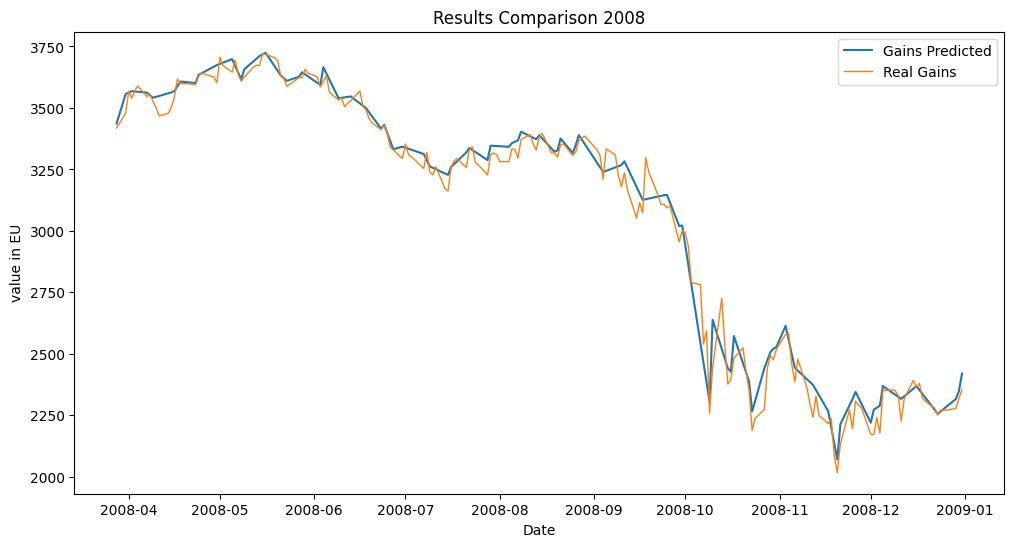

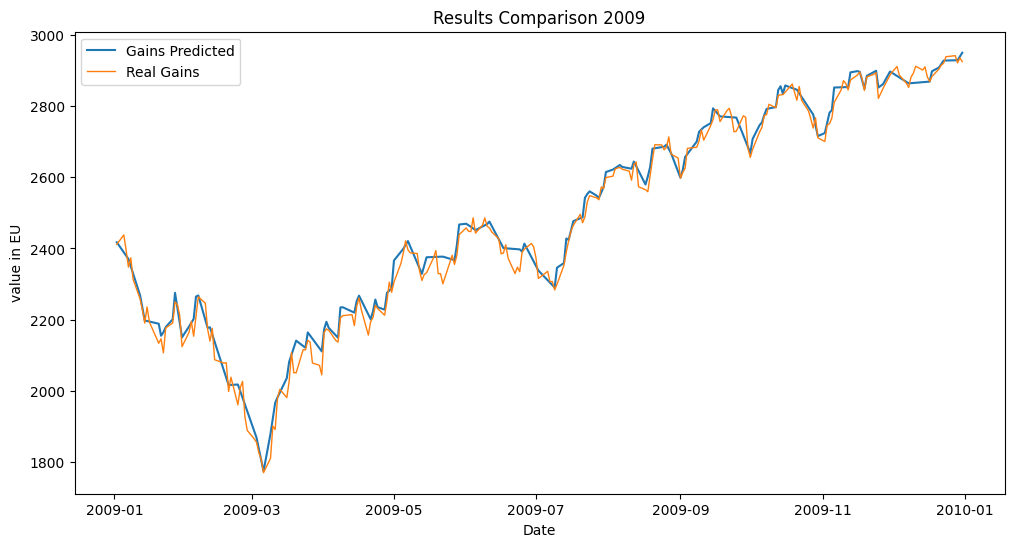

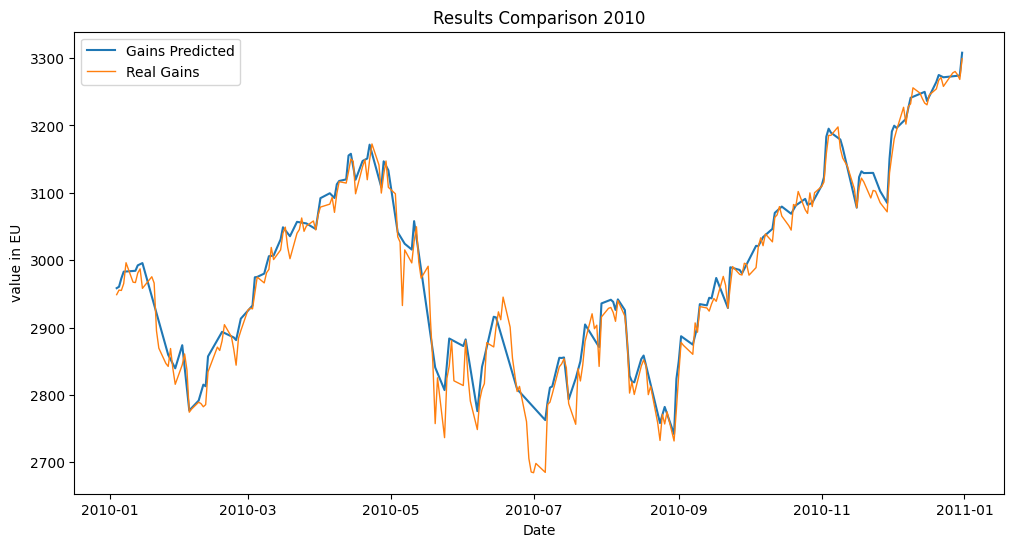

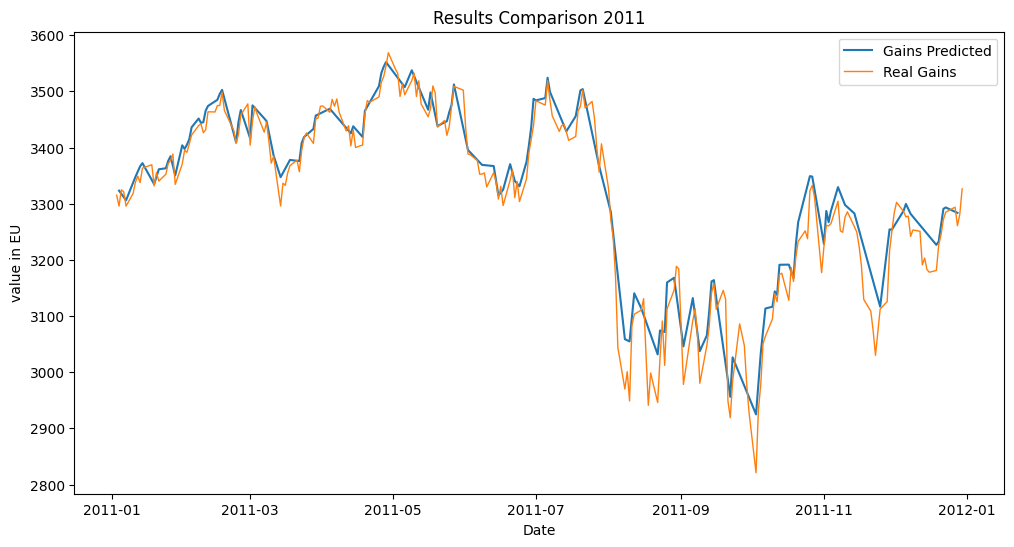

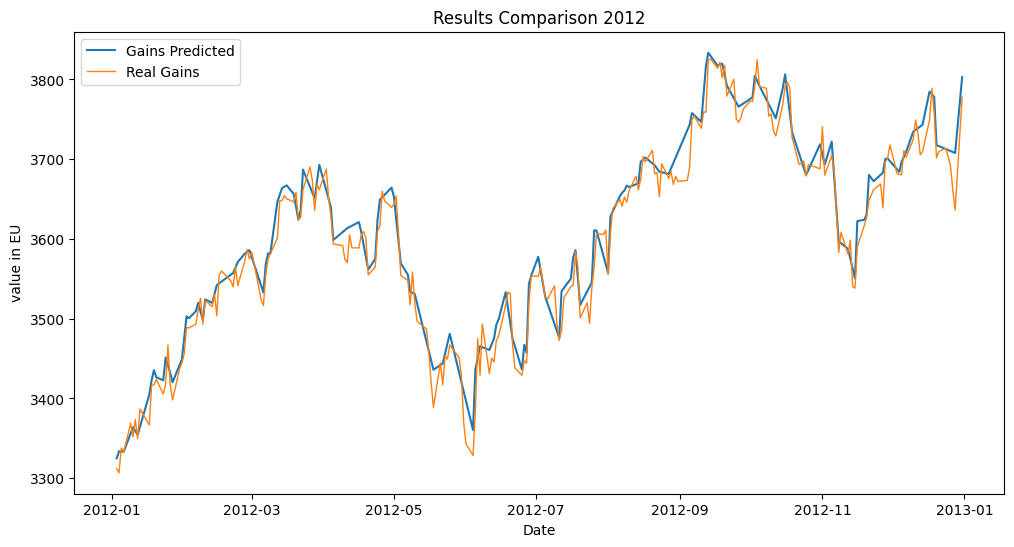

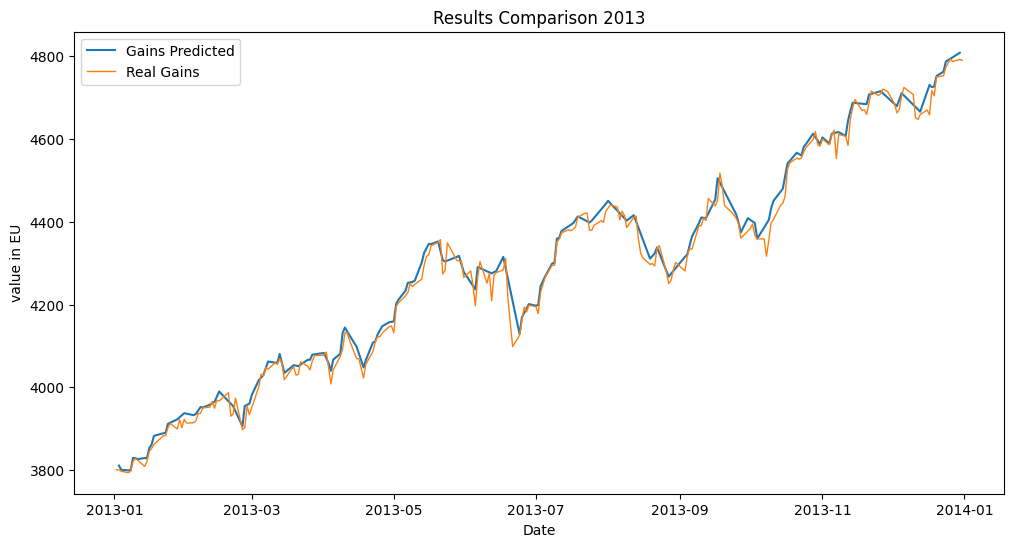

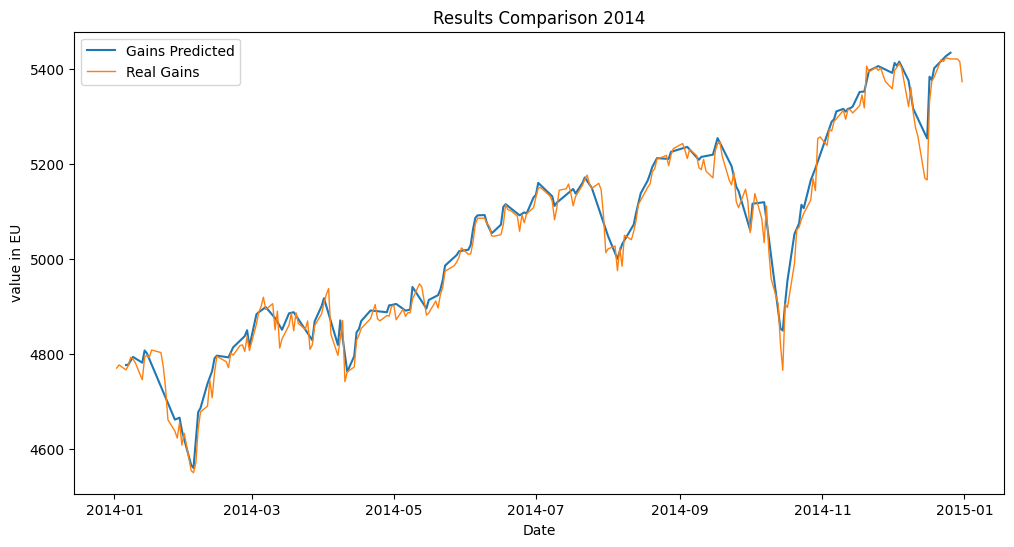

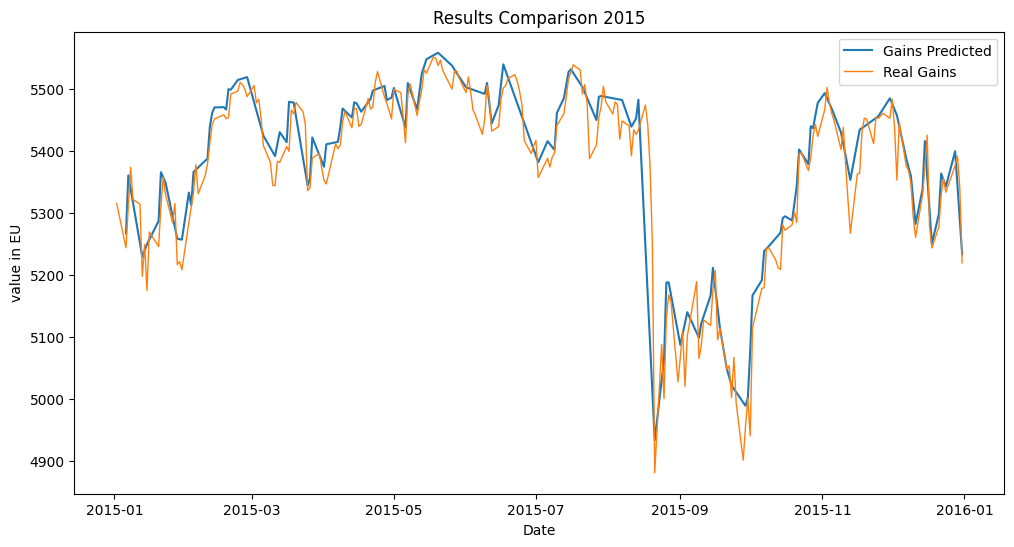

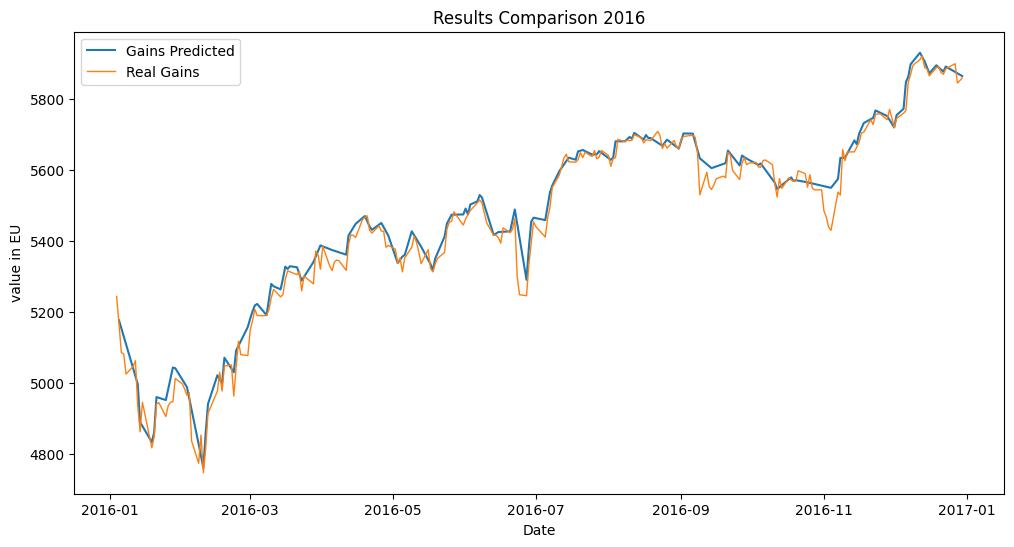

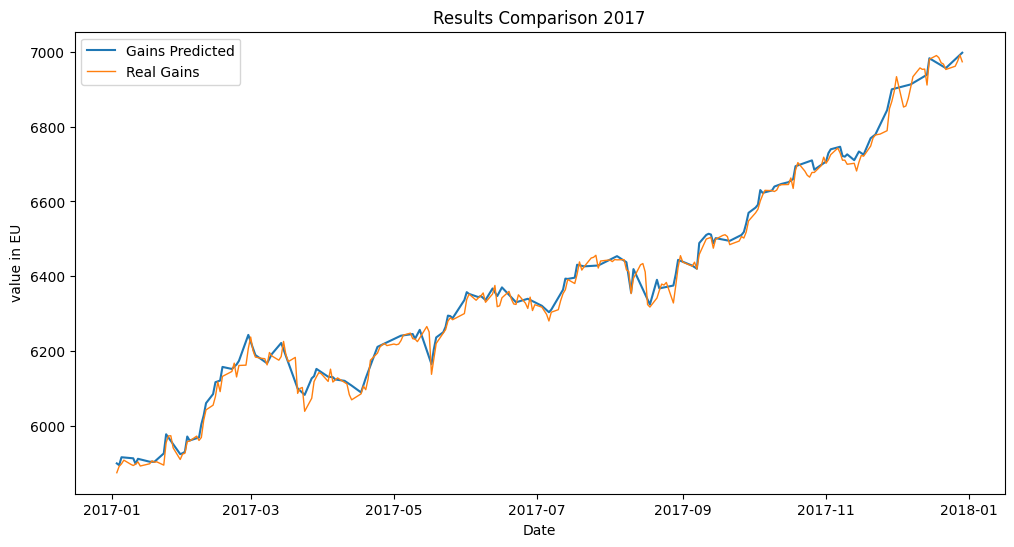

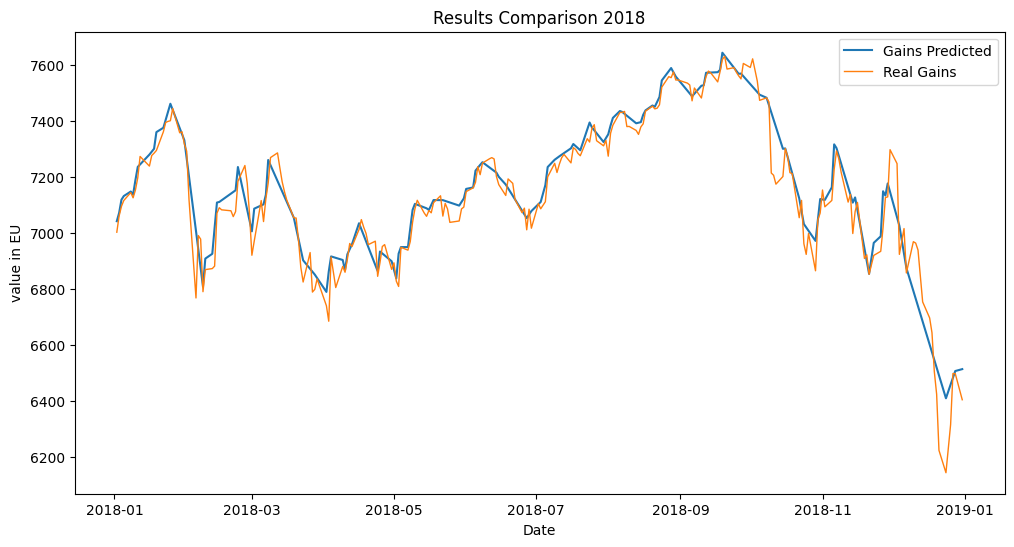

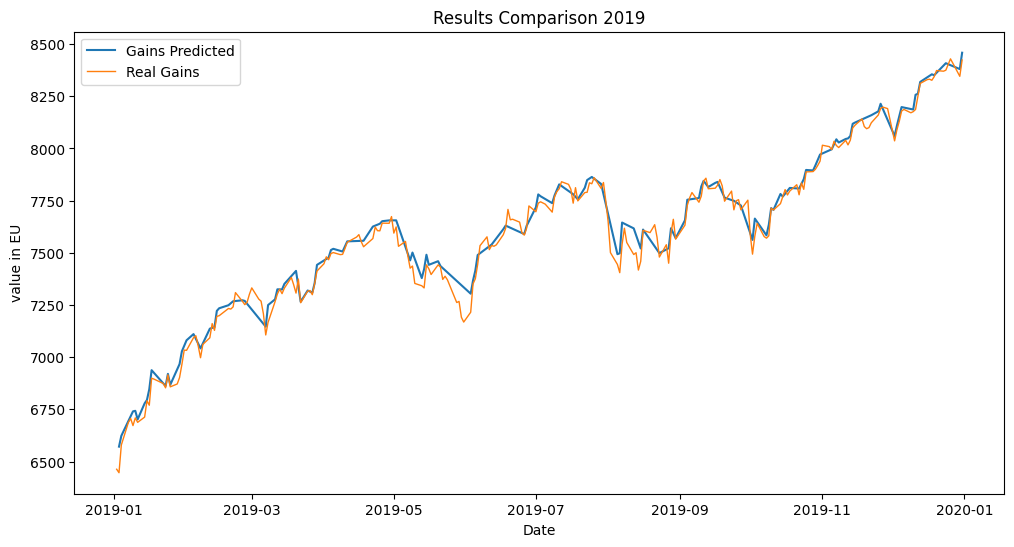

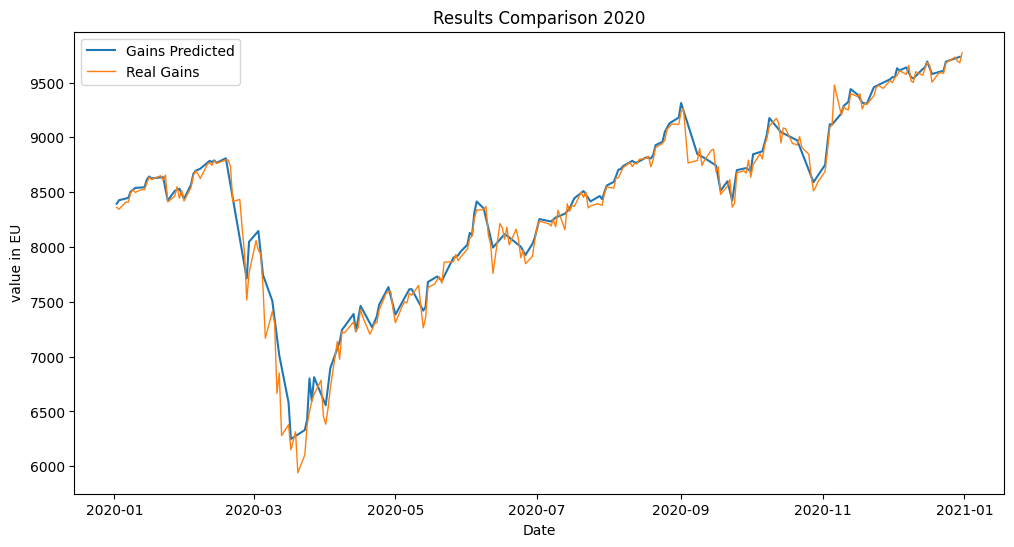

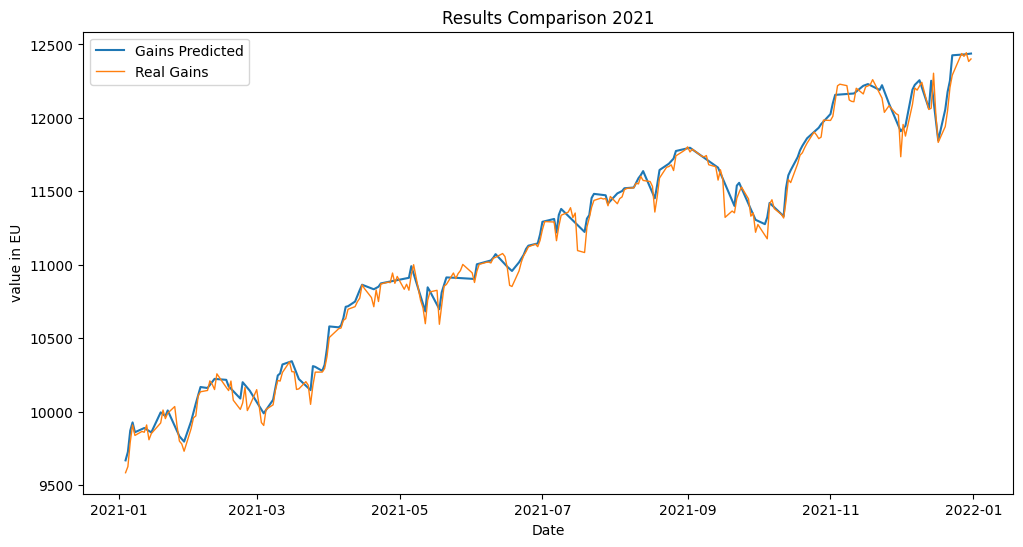

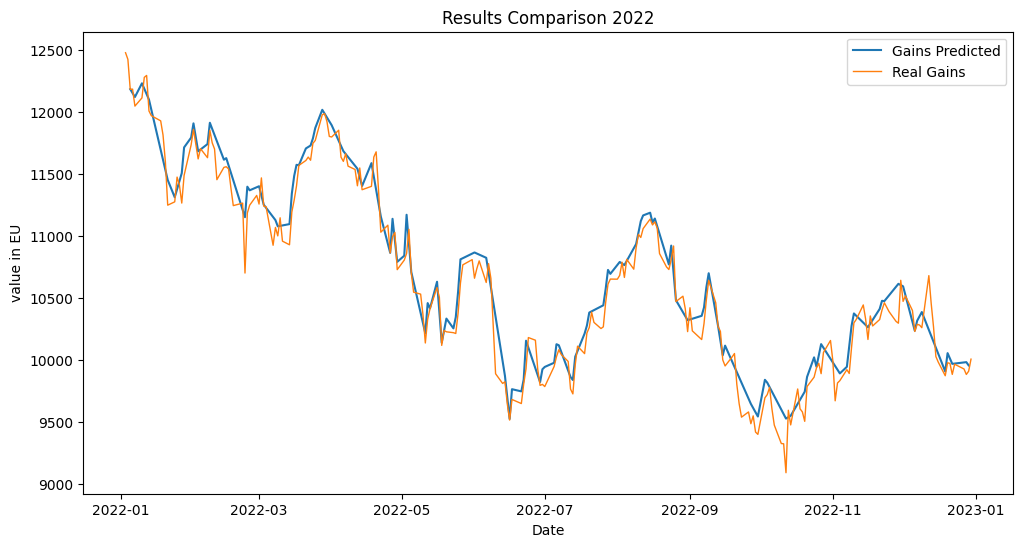

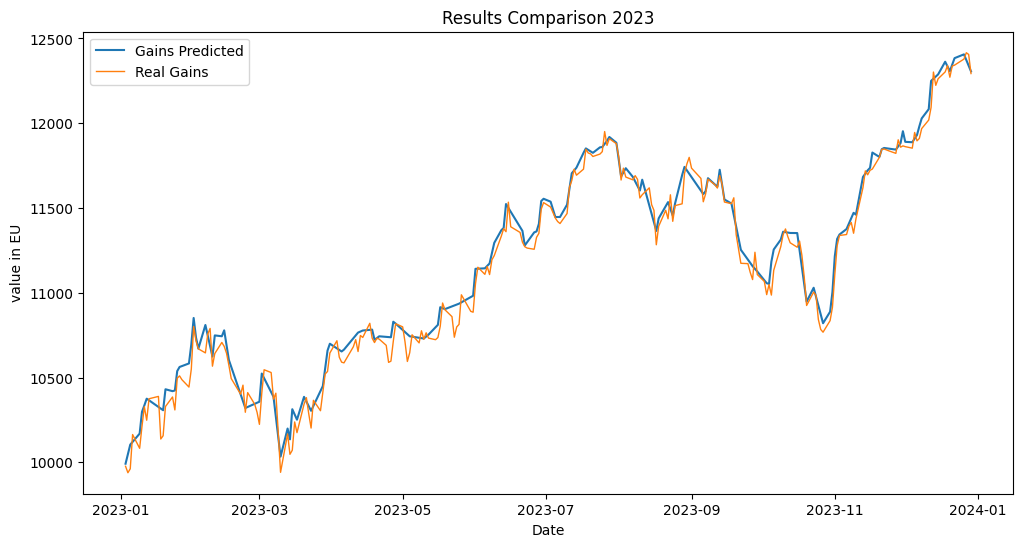

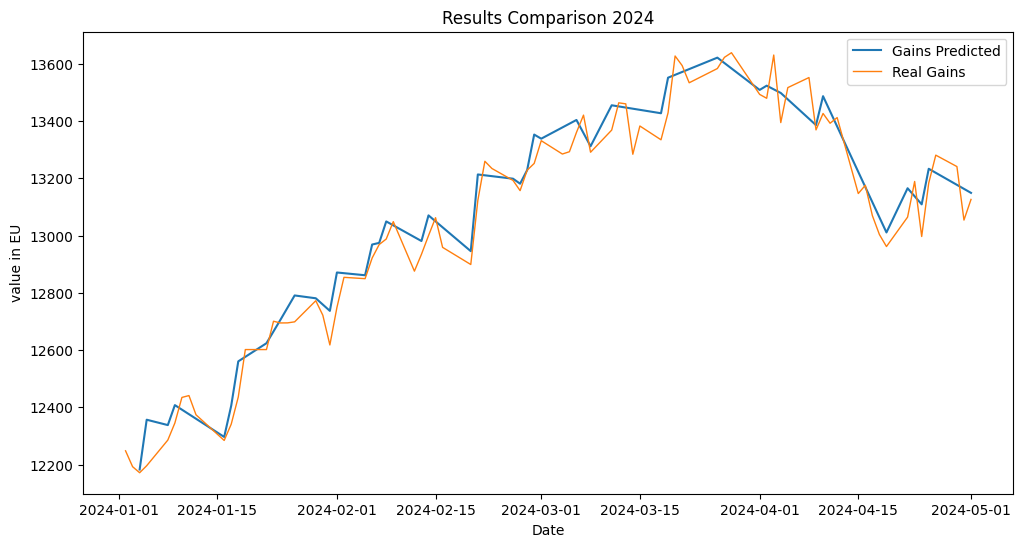

In [323]:
dif_periods = "2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024".split(" ")
for i in dif_periods:
    date_period(i)